In [1]:
import os
import zarr
import random
import json
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from pathlib import Path
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from collections import defaultdict
import sys
import torch
import torchvision.transforms.functional as F
import random

warnings.filterwarnings("ignore")
sys.path.append("./src/")

from src.config import CFG
from src.dataloader import (
    read_zarr,
    read_info_json,
    scale_coordinates,
    create_dataset,
    create_segmentation_map,
    EziiDataset,
    drop_padding,
)
from src.network import UNet_2D, aug
from src.utils import save_images
from src.metric import score, create_cls_pos, create_cls_pos_sikii, create_df
from metric import visualize_epoch_results

In [2]:
train_dataset = EziiDataset(
    exp_names=CFG.train_exp_names,
    base_dir="../../inputs/train/",
    particles_name=CFG.particles_name,
    resolution=CFG.resolution,
    zarr_type=CFG.train_zarr_types,
    train=True,
)

valid_dataset = EziiDataset(
    exp_names=CFG.valid_exp_names,
    base_dir="../../inputs/train/",
    particles_name=CFG.particles_name,
    resolution=CFG.resolution,
    zarr_type=CFG.valid_zarr_types,
    train=True,
)

from tqdm import tqdm

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
train_nshuffle_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)

for data in tqdm(train_dataset):
    normalized_tomogram = data["normalized_tomogram"]
    segmentation_map = data["segmentation_map"]
    break

# normalized_tomogram =
normalized_tomogram.shape[0]

[('TS_5_4', 'denoised'), ('TS_73_6', 'denoised'), ('TS_99_9', 'denoised'), ('TS_6_4', 'denoised'), ('TS_69_2', 'denoised')]
[('TS_86_3', 'denoised'), ('TS_6_6', 'denoised')]


  0%|          | 0/5 [00:00<?, ?it/s]


46

In [3]:
# torchのpadding用の関数
# torch.Size([4, 1, 158, 158]) -> torch.Size([4, 1, 160, 160])


class PadToSize(nn.Module):
    def __init__(self, resolution):
        super().__init__()
        if resolution == "0":
            self.size = 640
        elif resolution == "1":
            self.size = 320
        elif resolution == "2":
            self.size = 160

    def forward(self, x):
        return F.pad(x, (0, 0, self.size - x.shape[-1], self.size - x.shape[-2]))


# test
pad = PadToSize(CFG.resolution)
test_input = torch.randn((4, 1, 158, 158))
print(test_input.shape)
print(pad(test_input).shape)

torch.Size([4, 1, 158, 158])
torch.Size([4, 1, 160, 160])


In [4]:
model = UNet_2D().to("cuda")
model.eval()

UNet_2D(
  (model): Unet(
    (encoder): EfficientNetEncoder(
      (_conv_stem): Conv2dStaticSamePadding(
        1, 64, kernel_size=(3, 3), stride=(2, 2), bias=False
        (static_padding): ZeroPad2d((0, 1, 0, 1))
      )
      (_bn0): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_blocks): ModuleList(
        (0): MBConvBlock(
          (_depthwise_conv): Conv2dStaticSamePadding(
            64, 64, kernel_size=(3, 3), stride=[1, 1], groups=64, bias=False
            (static_padding): ZeroPad2d((1, 1, 1, 1))
          )
          (_bn1): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
          (_se_reduce): Conv2dStaticSamePadding(
            64, 16, kernel_size=(1, 1), stride=(1, 1)
            (static_padding): Identity()
          )
          (_se_expand): Conv2dStaticSamePadding(
            16, 64, kernel_size=(1, 1), stride=(1, 1)
            (static_padding): Identit

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

# サンプルデータ
num_classes = len(CFG.particles_name)  # クラス数
colors = plt.cm.tab10(
    np.arange(len(CFG.particles_name))
)  # "tab10" カラーマップから色を取得

# ListedColormap を作成
class_colormap = ListedColormap(colors)


# カラーバー付きプロット
def plot_with_colormap(data, title, original_tomogram):
    masked_data = np.ma.masked_where(data <= 0, data)  # クラス0をマスク
    plt.imshow(original_tomogram, cmap="gray")
    im = plt.imshow(masked_data, cmap=class_colormap)
    plt.title(title)
    plt.axis("off")
    return im

In [6]:
class SegmentationLoss(nn.Module):
    def __init__(self, criterion):
        super().__init__()
        self.softmax = nn.Softmax(dim=1)
        self.criterion = criterion

    def forward(self, output, target):
        # output: (batch, cls, 160, 160)
        # target: (batch, 160, 160)

        # output, (batch, 160, 160, cls) -> (batch, 160, 160, cls)
        output = output.permute(0, 2, 3, 1)
        output = output.reshape(-1, output.shape[-1])  # (batch*160*160, cls)

        # target, (batch, 160, 160) -> (batch*160*160)
        target = target.reshape(-1)

        loss = self.criterion(output, target)
        return loss

Train-nshuffle-Epoch: 0, Loss: 1.012803198316175: 100%|██████████| 230/230 [00:10<00:00, 22.47it/s] 


EPOCH: 0, TRAIN_SCORE: 0.0035361674624394324


Valid-Epoch: 0, Loss: 0.897854557544317: 100%|██████████| 92/92 [00:04<00:00, 21.64it/s]  


EPOCH: 0, VALID_SCORE: 0.011419785635057684


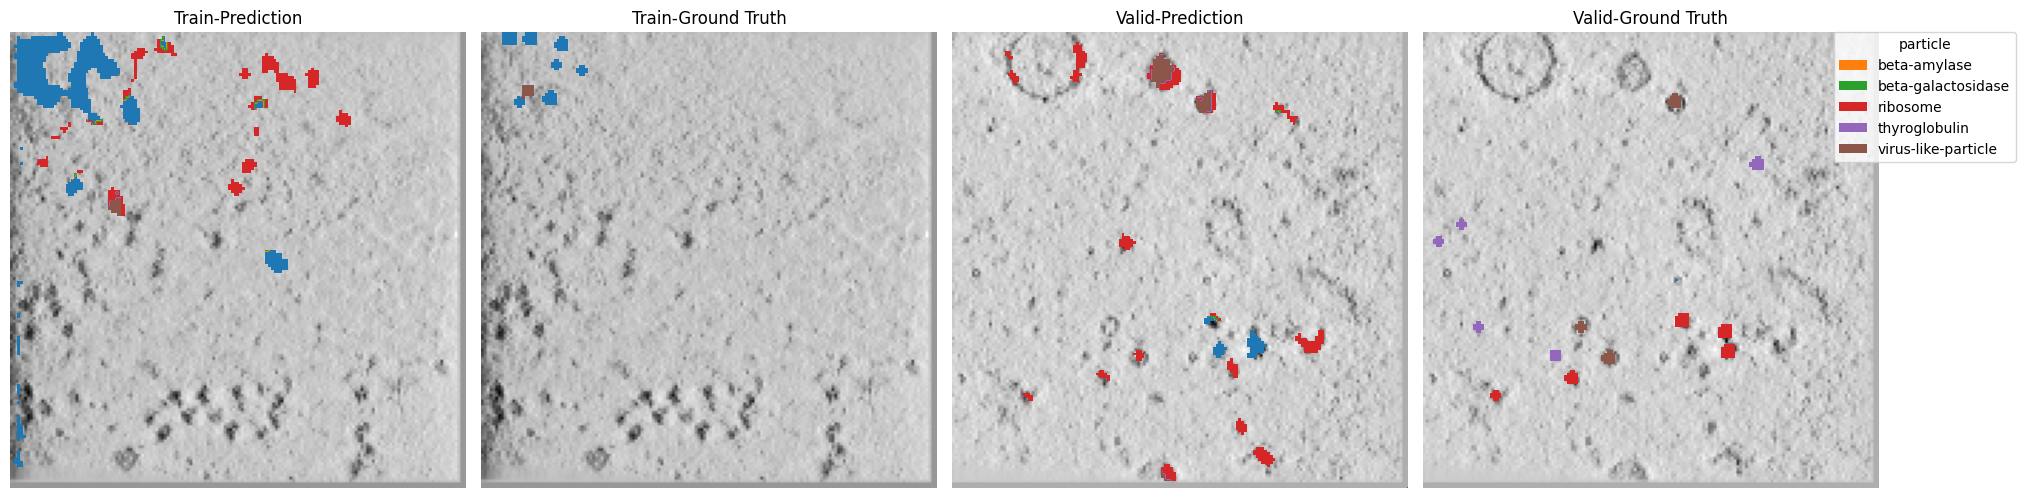

Train-Epoch: 1, Loss: 0.2737656837159937:  96%|█████████▋| 55/57 [00:24<00:00,  2.29it/s] 
Train-nshuffle-Epoch: 1, Loss: 0.4878014751588521: 100%|██████████| 230/230 [00:09<00:00, 24.15it/s] 


EPOCH: 1, TRAIN_SCORE: 0.002888917953623566


Valid-Epoch: 1, Loss: 0.5737807315814755: 100%|██████████| 92/92 [00:03<00:00, 23.27it/s] 


EPOCH: 1, VALID_SCORE: 0.002606766247715433


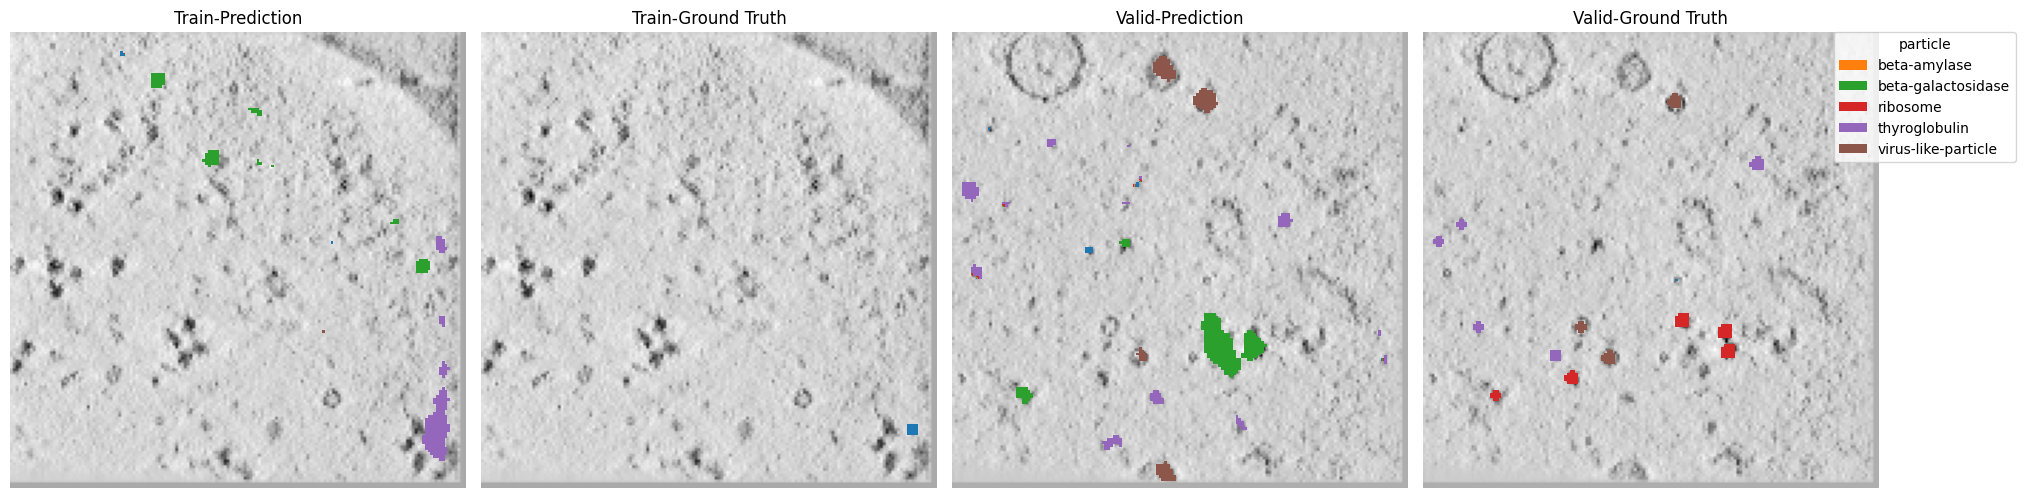

Train-nshuffle-Epoch: 2, Loss: 0.45096746755197: 100%|██████████| 230/230 [00:09<00:00, 23.17it/s]   


EPOCH: 2, TRAIN_SCORE: 0.0035748185316198553


Valid-Epoch: 2, Loss: 0.8873517310408794: 100%|██████████| 92/92 [00:03<00:00, 23.73it/s]


EPOCH: 2, VALID_SCORE: 0.0061858137988048435


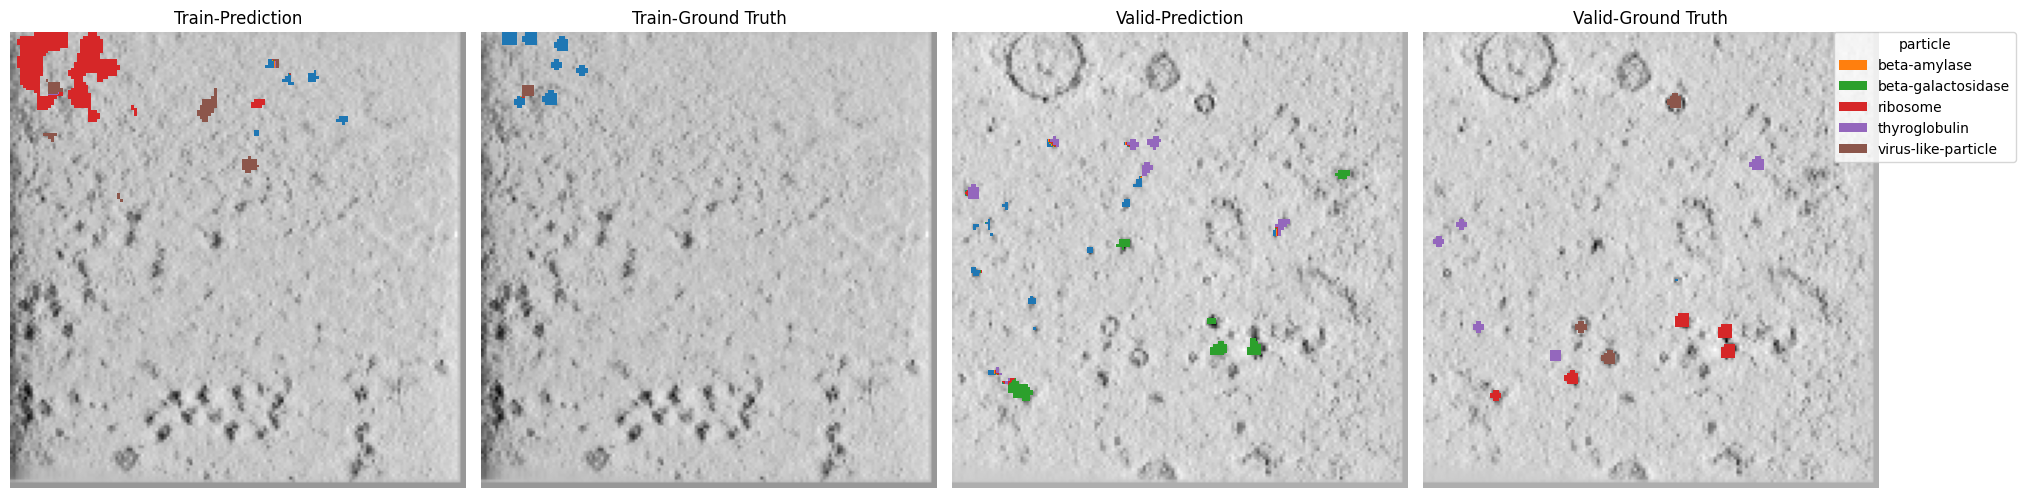

Train-Epoch: 3, Loss: 0.1181983695788817:  96%|█████████▋| 55/57 [00:24<00:00,  2.28it/s] 
Train-nshuffle-Epoch: 3, Loss: 0.4570225326972001: 100%|██████████| 230/230 [00:09<00:00, 24.48it/s] 


EPOCH: 3, TRAIN_SCORE: 0.004487186778298945


Valid-Epoch: 3, Loss: 1.1900269493065856: 100%|██████████| 92/92 [00:03<00:00, 23.39it/s] 


EPOCH: 3, VALID_SCORE: 0.0026675209585991532


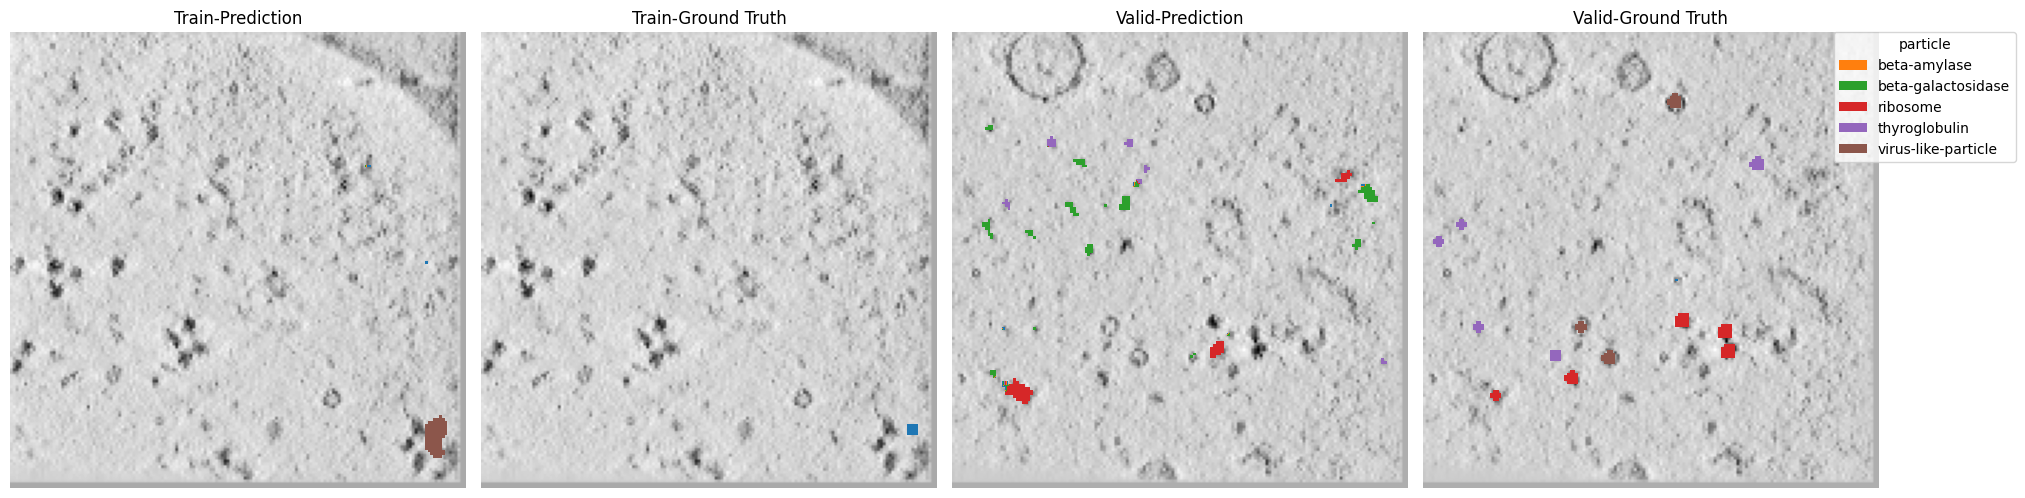

Train-Epoch: 4, Loss: 0.08972398462620648:  58%|█████▊    | 33/57 [00:14<00:10,  2.27it/s]

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss(
    weight=torch.tensor([0.5, 32, 32, 32, 32, 32, 32]).to("cuda")
)
seg_loss = SegmentationLoss(criterion)
padf = PadToSize(CFG.resolution)

best_model = None
best_score = 0
batch_size = 4

for epoch in range(100):
    train_loss = []
    train_nshuffle_loss = []
    valid_loss = []

    train_original_tomogram = defaultdict(list)
    train_pred_tomogram = defaultdict(list)
    train_gt_tomogram = defaultdict(list)

    train_nshuffle_original_tomogram = defaultdict(list)
    train_nshuffle_pred_tomogram = defaultdict(list)
    train_nshuffle_gt_tomogram = defaultdict(list)

    valid_original_tomogram = defaultdict(list)
    valid_pred_tomogram = defaultdict(list)
    valid_gt_tomogram = defaultdict(list)

    model.train()
    tq = tqdm(range(len(train_loader) * normalized_tomogram.shape[0] // batch_size))
    for data in train_loader:
        exp_name = data["exp_name"][0]
        tomogram = data["normalized_tomogram"]
        segmentation_map = data["segmentation_map"].long()

        train_original_tomogram[exp_name] = (
            padf(tomogram).squeeze().cpu().detach().numpy()
        )

        for i in range(batch_size, tomogram.shape[1], batch_size):
            optimizer.zero_grad()

            # random_indices = [12, 21, 15, 10]
            # random_indices = list(
            #     torch.randperm(normalized_tomogram.shape[0]).detach().numpy()
            # )[:batch_size]

            # ランダムに選択した行を取得
            # random_input_ = tomogram[:, random_indices].transpose(0, 1)
            # random_gt = segmentation_map[:, random_indices].squeeze()
            random_input_ = tomogram.transpose(0, 1)
            random_gt = segmentation_map.squeeze()

            # random_input_ = tomogram[:, random_index]
            # random_input_ = random_input_.transpose(0, 1)  # (batch_size, 158, 158)
            # random_gt = xxxx.squeeze()  # (batch_size, 158, 158)

            # random_input_, random_gtを作成(ランダムだけど同じindex)

            # input_, gt = aug(input_, gt)
            random_input_ = random_input_.to("cuda")
            random_gt = random_gt.to("cuda")
            random_input_ = padf(random_input_)
            random_gt = padf(random_gt)
            output = model(random_input_)
            loss = seg_loss(output, random_gt)
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())
            tq.set_description(f"Train-Epoch: {epoch}, Loss: {np.mean(train_loss)}")
            tq.update(1)

            # print(output.shape, gt.shape)  # torch.Size([4, 7, 160, 160]) torch.Size([4, 160, 160])
            for i in range(batch_size):
                train_pred_tomogram[exp_name].append(output[i].cpu().detach().numpy())
                train_gt_tomogram[exp_name].append(random_gt[i].cpu().detach().numpy())
    tq.close()
    train_exp_name = exp_name

    ######################################## train-nshuffle #########################################
    model.eval()
    tq = tqdm(range(len(train_nshuffle_loader) * normalized_tomogram.shape[0]))
    for data in train_nshuffle_loader:
        exp_name = data["exp_name"][0]
        tomogram = data["normalized_tomogram"].to("cuda")
        segmentation_map = data["segmentation_map"].to("cuda").long()

        train_nshuffle_original_tomogram[exp_name] = (
            padf(tomogram).squeeze().cpu().detach().numpy()
        )

        for i in range(tomogram.shape[1]):
            input_ = tomogram[:, i].unsqueeze(0)
            gt = segmentation_map[:, i]

            input_ = padf(input_)
            gt = padf(gt)
            output = model(input_)
            loss = seg_loss(output, gt)

            train_nshuffle_loss.append(loss.item())
            tq.set_description(
                f"Train-nshuffle-Epoch: {epoch}, Loss: {np.mean(train_nshuffle_loss)}"
            )
            tq.update(1)

            # print(output.shape, gt.shape) # torch.Size([1, 7, 160, 160]) torch.Size([1, 160, 160])
            train_nshuffle_pred_tomogram[exp_name].append(output.cpu().detach().numpy())
            train_nshuffle_gt_tomogram[exp_name].append(gt.cpu().detach().numpy())
    tq.close()

    train_score_ = visualize_epoch_results(
        train_nshuffle_pred_tomogram,
        base_dir="../../inputs/train/overlay/ExperimentRuns/",
        sikii_dict=CFG.initial_sikii,
    )
    print(f"EPOCH: {epoch}, TRAIN_SCORE: {train_score_}")

    ############################################# valid #############################################

    model.eval()
    tq = tqdm(range(len(valid_loader) * normalized_tomogram.shape[0]))
    for data in valid_loader:
        exp_name = data["exp_name"][0]
        tomogram = data["normalized_tomogram"].to("cuda")
        segmentation_map = data["segmentation_map"].to("cuda").long()

        valid_original_tomogram[exp_name] = (
            padf(tomogram).squeeze().cpu().detach().numpy()
        )

        for i in range(tomogram.shape[1]):
            input_ = tomogram[:, i].unsqueeze(0)
            gt = segmentation_map[:, i]

            input_ = padf(input_)
            gt = padf(gt)
            output = model(input_)
            loss = seg_loss(output, gt)

            valid_loss.append(loss.item())
            tq.set_description(f"Valid-Epoch: {epoch}, Loss: {np.mean(valid_loss)}")
            tq.update(1)

            # print(output.shape, gt.shape) # torch.Size([1, 7, 160, 160]) torch.Size([1, 160, 160])
            valid_pred_tomogram[exp_name].append(output.cpu().detach().numpy())
            valid_gt_tomogram[exp_name].append(gt.cpu().detach().numpy())
    tq.close()
    valid_exp_name = exp_name

    valid_score_ = visualize_epoch_results(
        valid_pred_tomogram,
        base_dir="../../inputs/train/overlay/ExperimentRuns/",
        sikii_dict=CFG.initial_sikii,
    )

    print(f"EPOCH: {epoch}, VALID_SCORE: {valid_score_}")

    if valid_score_ > best_score:
        best_score = valid_score_
        best_model = model
        torch.save(model.state_dict(), f"best_model.pth")

    # 描画
    index = 30
    plt.figure(figsize=(20, 5))

    # Train-Pred-Plot
    ax = plt.subplot(1, 4, 1)
    pred = train_pred_tomogram[train_exp_name][index].argmax(0)
    im = plot_with_colormap(
        pred, "Train-Prediction", train_original_tomogram[train_exp_name][index]
    )

    # Train-GT-Plot
    ax = plt.subplot(1, 4, 2)
    gt = train_gt_tomogram[train_exp_name][index]
    plot_with_colormap(
        gt, "Train-Ground Truth", train_original_tomogram[train_exp_name][index]
    )

    # Valid-Pred-Plot
    ax = plt.subplot(1, 4, 3)
    pred = valid_pred_tomogram[valid_exp_name][index][0].argmax(0)
    plot_with_colormap(
        pred, "Valid-Prediction", valid_original_tomogram[valid_exp_name][index]
    )

    # Valid-GT-Plot
    ax = plt.subplot(1, 4, 4)
    gt = valid_gt_tomogram[valid_exp_name][index][0]
    plot_with_colormap(
        gt, "Valid-Ground Truth", valid_original_tomogram[valid_exp_name][index]
    )

    # 凡例を追加
    legend_elements = [
        Patch(facecolor=colors[i], label=CFG.particles_name[i])
        for i in range(1, num_classes)
    ]
    plt.legend(
        handles=legend_elements,
        loc="upper right",
        title="particle",
        bbox_to_anchor=(1.3, 1),  # 凡例を右上に配置
        borderaxespad=0,
    )

    plt.tight_layout()
    plt.show()

# save_images(
#     train_gt_tomogram=train_gt_tomogram,
#     train_pred_tomogram=train_pred_tomogram,
#     valid_gt_tomogram=valid_gt_tomogram,
#     valid_pred_tomogram=valid_pred_tomogram,
#     save_dir="images",
#     epoch=epoch,
# )

In [ ]:
list(random_indices.detach().numpy())